[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is the latest model in the YOLO series, developed by Yunjie Tian, Qixiang Ye, David Doermann and introduced in the paper [YOLOv12: Attention-Centric Real-Time Object Detectors](https://arxiv.org/abs/2502.12524).

This model achieves both lower latency and higher mAP than previous state-of-the-art models like YOLOv11, YOLOv10, and RT-DETR.

<img src="https://raw.githubusercontent.com/sunsmarterjie/yolov12/main/assets/tradeoff.svg" width=100%>

In this guide, we are going to walk through how to fine-tune a YOLOv12 model on a custom dataset.

Without further ado, let's get started!

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install YOLOv12
- Download pre-trained weights
- Download example data
- Inference with Pre-trained COCO Model
- Download dataset from Roboflow Universe
- Custom Training
- Validate Custom Model
- Inference with Custom Model

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Wed Feb 19 14:22:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv12 from Source

**NOTE:** Currently, YOLOv12 does not have its own PyPI package. Therefore, we need to install the code from the source.

You can install YOLOv12 with the code below:

In [ ]:
!git clone https://github.com/sunsmarterjie/yolov12
%cd yolov12
!pip install roboflow supervision flash-attn --upgrade -q
!pip install -r requirements.txt
!pip install -e .
!pip install --upgrade flash-attn

Cloning into 'yolov12'...
remote: Enumerating objects: 691, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (159/159), done.
remote: Total 691 (delta 90), reused 0 (delta 0), pack-reused 530 (from 1)
Receiving objects: 100% (691/691), 1.38 MiB | 8.83 MiB/s, done.
Resolving deltas: 100% (281/281), done.
/content/yolov12
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 51.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Download example data

Next, let's download an example image of a person and a dog that we can use to test our model:

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-02-19 14:23:57--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-02-19 14:23:57 (118 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

Let's run the `yolov12n` base model that was trained using the Microsoft COCO dataset. This model comes out of the box with YOLOv12.

We will then use the Roboflow `supervision` Python package to visualize the results from our model.

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


100%|██████████| 5.34M/5.34M [00:00<00:00, 65.8MB/s]



0: 640x384 1 person, 1 car, 2 dogs, 73.2ms
Speed: 3.5ms preprocess, 73.2ms inference, 296.0ms postprocess per image at shape (1, 3, 640, 384)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


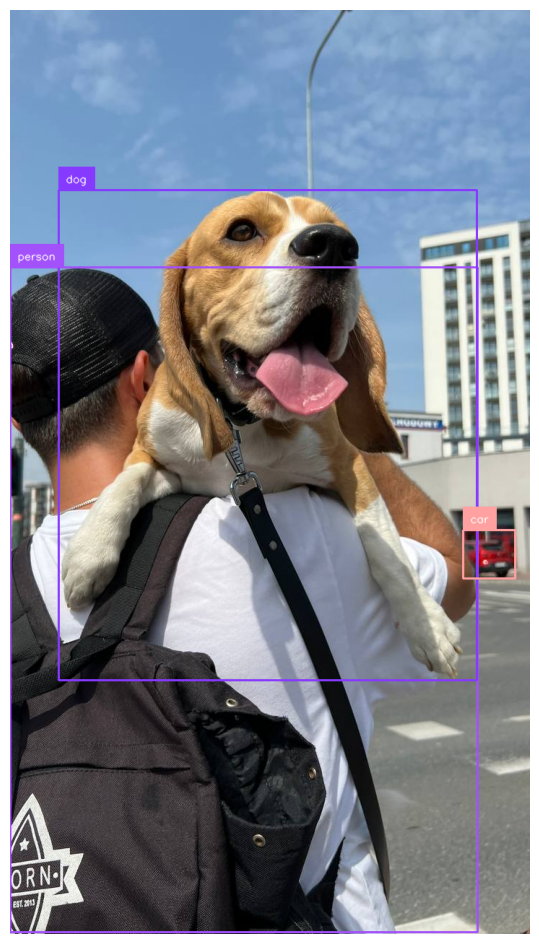

In [ ]:
from ultralytics import YOLO
import supervision as sv
import cv2

image = cv2.imread("dog.jpeg")

model = YOLO('yolov12n.pt')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

The YOLOv12 model successfully identifies the person and dog in the image.

You can experiment with different model sizes by replacing `yolov12n.pt` with:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

## Train a model

Now, let's fine-tune a YOLOv12 model using a custom dataset.

For this guide, we will use a yard management dataset hosted on Roboflow Universe. This dataset contains images of shipping containers and other industrial objects.

We will:

- Download the dataset
- Train the model
- View the trained model confusion matrix
- Run our model on an image

### Download dataset from Roboflow Universe

If you do not already have one, create a [free Roboflow account](https://app.roboflow.com). When you run the code below, you will be asked for your API key. This will allow you to export the dataset we will use for training.

You can use any dataset in the [YOLOv8 PyTorch TXT format](https://roboflow.com/formats/yolov8-pytorch-txt).

In [ ]:
from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')

rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("roboflow-universe-projects").project("yard-management-system")
version = project.version(11)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Yard-Management-System-11 in yolov8:: 100%|██████████| 326/326 [00:00<00:00, 7877.76it/s]


We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following code to prepare your dataset for training:

In [ ]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

### Train the model

We are now ready to train a YOLOv12 model.

Below, repalce `yolov12s.yaml` with the checkpoint from which you want to start training. You can use:

- yolov12n.pt
- yolov12s.pt
- yolov12m.pt
- yolov12l.pt
- yolov12x.pt

We recommend training for at least 250 epochs.

Once you have set your training checkpoint, run the code cell below to start training.

**Note ⚠️:** After all epochs run, the `model()` will return a `TypeError: argument of type 'PosixPath' is not iterable` error. This has been [filed as an issue](https://github.com/sunsmarterjie/yolov12/issues/2). If you see this error after training, your model weights will still be saved and you can safely proceed to running inference.

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov12s.yaml')

results = model.train(
  data=f'{dataset.location}/data.yaml',
  epochs=250
)

New https://pypi.org/project/ultralytics/8.3.76 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/content/yolov12/Yard-Management-System-11/data.yaml, epochs=250, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=

100%|██████████| 755k/755k [00:00<00:00, 14.7MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689920  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

train: Scanning /content/yolov12/Yard-Management-System-11/train/labels... 110 images, 37 backgrounds, 0 corrupt: 100%|██████████| 110/110 [00:00<00:00, 1596.16it/s]

train: New cache created: /content/yolov12/Yard-Management-System-11/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/yolov12/Yard-Management-System-11/valid/labels... 31 images, 13 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 1373.87it/s]

val: New cache created: /content/yolov12/Yard-Management-System-11/valid/labels.cache


Plotting labels to /content/yolov12/runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: WARNING ⚠️ TensorBoard graph visualization failure Tracing failed sanity checks!
ERROR: Graphs differed across invocations!
	Graph diff:
		  graph(%self.1 : __torch__.ultralytics.nn.tasks.DetectionModel,
		        %x.1 : Tensor):
		    %model : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_21 : __torch__.ultralytics.nn.modules.head.Detect = prim::GetAttr[name="21"](%model)
		    %model.43 : __torch__.torch.nn.modules.container.Sequential = prim::GetAttr[name="model"](%self.1)
		    %_20 : __torch__.ultralytics.nn.modules.block.C3k2 = prim::GetAttr[name="20"](%model.43)
		    %mod

      1/250      5.04G      4.276      4.981      4.205         59        640: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

                   all         31        121   0.000996     0.0481   0.000595   0.000215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      4.95G       4.21      5.005      4.234        102        640: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         31        121   0.000983     0.0481   0.000735   0.000402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      4.95G      4.181      4.914      4.171         61        640: 100%|██████████| 7/7 [00:01<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         31        121   0.000996     0.0481   0.000744    0.00036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      4.95G      4.274      4.864      4.149        103        640: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         31        121    0.00106     0.0481   0.000814   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      4.98G       4.28      4.944      4.127         56        640: 100%|██████████| 7/7 [00:01<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         31        121    0.00105     0.0481   0.000696   0.000269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      4.94G      4.004      4.513      4.018         78        640: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         31        121    0.00102     0.0481   0.000749   0.000338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      4.99G      3.973      4.416      3.946         76        640: 100%|██████████| 7/7 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         31        121    0.00105     0.0481    0.00184   0.000557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      4.96G      3.749       4.16      3.835         59        640: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         31        121    0.00104     0.0481    0.00164   0.000457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      4.99G       3.66      3.905      3.756         70        640: 100%|██████████| 7/7 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.04it/s]

                   all         31        121    0.00106     0.0481     0.0015   0.000458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      4.98G      3.639      3.922      3.719        131        640: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.69it/s]

                   all         31        121    0.00105     0.0481    0.00214   0.000678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      4.99G      3.736      3.969      3.559         59        640: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121    0.00103     0.0481    0.00765    0.00175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      4.97G      3.764      3.801      3.549         63        640: 100%|██████████| 7/7 [00:01<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.99it/s]

                   all         31        121    0.00157     0.0481   0.000983   0.000233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250         5G      3.561      3.643      3.399         95        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121    0.00162     0.0481    0.00141   0.000261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      4.98G      3.522      3.492      3.396         68        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121    0.00147     0.0481    0.00206   0.000454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      4.98G      3.388      3.337      3.245         80        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]

                   all         31        121    0.00102      0.106    0.00242    0.00073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      5.01G      3.226      3.276      3.268         87        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


                   all         31        121      0.757     0.0721     0.0111    0.00334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      4.97G       3.15      3.306      3.182        115        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]

                   all         31        121      0.771     0.0529    0.00997    0.00301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      4.98G      2.999        3.1      3.084        100        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]

                   all         31        121      0.509     0.0481    0.00756    0.00184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      4.99G      2.974      2.963      2.991        121        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.27it/s]

                   all         31        121     0.0273      0.135     0.0296    0.00775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      4.93G      2.968      3.006      2.999         66        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         31        121      0.332      0.122     0.0601     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250         5G      2.808      2.769      2.874         88        640: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]

                   all         31        121      0.294      0.131     0.0487     0.0133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      4.98G      2.879      2.787      2.943         68        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         31        121      0.662     0.0913     0.0935     0.0309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      4.99G      2.743      2.649      2.811        128        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.06it/s]

                   all         31        121      0.347     0.0996     0.0751     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      4.94G      2.708      2.634      2.684         68        640: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]

                   all         31        121      0.161      0.191      0.119     0.0331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250         5G      2.694      2.571      2.701         58        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

                   all         31        121      0.216      0.169      0.136     0.0453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      4.93G      2.791      2.556      2.774         89        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]

                   all         31        121      0.237      0.268       0.19     0.0691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      4.94G      2.675      2.473       2.66         85        640: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]

                   all         31        121      0.522      0.235      0.222     0.0871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      4.98G      2.615      2.491      2.568         89        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.485       0.31      0.223     0.0766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      4.98G       2.57       2.36      2.587         82        640: 100%|██████████| 7/7 [00:00<00:00,  7.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         31        121      0.487      0.315       0.23     0.0896



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      4.98G      2.629      2.425      2.593         75        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         31        121      0.491      0.329      0.239     0.0999



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      5.02G      2.608      2.391      2.529         89        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         31        121      0.691      0.308      0.307       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      4.99G      2.499       2.22        2.5         93        640: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         31        121      0.657      0.355      0.348      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      4.98G       2.42      2.238       2.52         85        640: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         31        121      0.626       0.36      0.352      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      5.02G       2.47      2.259      2.498         55        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         31        121      0.709      0.315      0.335      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250         5G      2.454      2.243      2.435         80        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         31        121      0.608      0.385      0.364      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      5.01G      2.478      2.245      2.479         58        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.776      0.313      0.385      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      4.97G      2.414      2.259      2.436        103        640: 100%|██████████| 7/7 [00:00<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         31        121      0.769      0.297      0.384      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      4.98G      2.399      2.196      2.404         83        640: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.74it/s]

                   all         31        121      0.652      0.306      0.297      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      5.02G      2.375      2.154      2.306        100        640: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         31        121      0.606      0.298      0.292      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      4.98G      2.376      2.112      2.339        102        640: 100%|██████████| 7/7 [00:00<00:00,  7.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.628      0.356      0.384      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      4.97G      2.407       1.98      2.295        104        640: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         31        121      0.643      0.365      0.403      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      5.01G      2.299      2.029      2.287        105        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]

                   all         31        121      0.627      0.373      0.403      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      4.94G      2.267      1.962      2.231        105        640: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         31        121      0.671      0.321      0.463      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      4.94G       2.24      1.919      2.203        104        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         31        121      0.695       0.33       0.51      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250      4.93G      2.154       1.82      2.149        103        640: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         31        121      0.684      0.343      0.474      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      4.96G       2.24      1.911      2.191         62        640: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121       0.33      0.577      0.469      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      4.94G      2.307       1.91      2.288        113        640: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         31        121       0.45      0.575      0.516      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      4.99G      2.263      1.962      2.232        120        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         31        121      0.592      0.539       0.56      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      4.97G      2.239      1.917      2.132         56        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         31        121      0.529      0.498      0.533      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      4.98G      2.185      1.816      2.135         71        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         31        121      0.437      0.584      0.493      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      4.93G      2.214      1.917      2.155         63        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         31        121      0.345      0.594      0.441       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      4.95G      2.153      1.771      2.113         91        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.72it/s]

                   all         31        121      0.469      0.612      0.564       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250         5G      2.152       1.87      2.135        123        640: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]

                   all         31        121      0.498      0.615      0.577      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      4.98G      2.068      1.727      2.065         82        640: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121      0.468      0.584      0.548      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250      4.99G      2.074      1.784      2.092         46        640: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         31        121      0.449      0.612      0.593      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      5.01G      2.117      1.746      2.084        101        640: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.458      0.672      0.594      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250         5G      2.068      1.672      2.087         65        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         31        121      0.481      0.613      0.609      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      4.96G      2.021      1.717      1.968         83        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         31        121      0.552       0.63       0.64      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      4.98G      1.958      1.623      1.908         57        640: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.536      0.671      0.607      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      4.99G      1.989      1.601      1.971         92        640: 100%|██████████| 7/7 [00:01<00:00,  7.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.94it/s]

                   all         31        121      0.512      0.659      0.628        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250      4.92G       2.12      1.695      2.005        116        640: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         31        121      0.596      0.618      0.639      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      4.95G      1.993      1.598      1.907        106        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.566      0.613      0.602      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250         5G      2.022      1.684      1.982         51        640: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121       0.58      0.637       0.63      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      5.01G      1.947      1.537      1.927         79        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         31        121      0.558      0.693      0.614      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250         5G      1.935      1.507      1.905         84        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         31        121      0.612      0.682      0.636      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      4.98G      1.963      1.516      1.906         79        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         31        121      0.577      0.721      0.633      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250         5G      1.989      1.636       1.96         80        640: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         31        121      0.615      0.723      0.693      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250      4.98G      1.876      1.503      1.848         97        640: 100%|██████████| 7/7 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         31        121       0.57      0.697      0.693      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250         5G      1.909      1.565      1.904         69        640: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.562      0.697      0.711      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      4.93G       1.88      1.483       1.86         64        640: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         31        121      0.642      0.554      0.678      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250         5G      1.951      1.564      1.927         85        640: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         31        121      0.628      0.621       0.65       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      4.99G      1.958      1.601      1.921         74        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121       0.59       0.72      0.694       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      4.92G      1.916      1.594      1.906         62        640: 100%|██████████| 7/7 [00:00<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.688      0.735      0.763      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      4.95G      1.851        1.5      1.828         73        640: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         31        121      0.694      0.705      0.719      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      4.93G      1.884      1.479      1.838         93        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121       0.68      0.648      0.721      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      4.93G      1.798      1.388      1.769        114        640: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121      0.627      0.686      0.662       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      4.94G       1.81      1.482      1.824         77        640: 100%|██████████| 7/7 [00:00<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         31        121      0.631      0.703      0.676      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250      5.01G      1.798        1.5      1.836         53        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121      0.662      0.729      0.726      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      5.02G      1.926      1.524       1.89         73        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         31        121      0.653      0.761      0.728      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      5.01G      1.884      1.525      1.855         91        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121      0.653      0.753      0.702      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      4.98G      1.806       1.45      1.826         70        640: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         31        121      0.596      0.738      0.685      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250      4.98G      1.819      1.431      1.793         64        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         31        121       0.71      0.626      0.672      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      4.97G      1.796      1.417      1.783        111        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         31        121      0.726      0.653      0.736      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      4.98G      1.854      1.454      1.775         71        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         31        121      0.622      0.684      0.711      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      4.97G      1.736       1.41      1.764        100        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.14it/s]

                   all         31        121      0.712      0.621      0.724      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      4.94G      1.782      1.387      1.733        105        640: 100%|██████████| 7/7 [00:00<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.22it/s]

                   all         31        121      0.755      0.705      0.781      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      4.95G      1.775      1.358      1.748        104        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         31        121      0.685      0.672      0.712      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      4.96G      1.755      1.403      1.769         65        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.783      0.599      0.733      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      4.92G      1.683      1.334      1.707         51        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         31        121      0.708      0.732      0.759      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      4.97G      1.877      1.447      1.796         52        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.757      0.681      0.762      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250         5G      1.654      1.258      1.676        107        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.04it/s]

                   all         31        121      0.718      0.702      0.777       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      4.94G      1.714      1.303      1.691         90        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.688       0.77       0.75      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250         5G      1.672      1.303      1.722         66        640: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         31        121      0.672       0.79      0.746      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      5.01G      1.754      1.381      1.764         61        640: 100%|██████████| 7/7 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.76it/s]

                   all         31        121      0.755      0.611      0.683      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      4.94G      1.637      1.269      1.619         79        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         31        121      0.723      0.738      0.704      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250      4.95G      1.737      1.323      1.744         82        640: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.705      0.733      0.739      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      4.93G      1.738      1.301      1.693        129        640: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.722      0.688      0.754      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250         5G      1.682      1.226      1.629        118        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         31        121      0.731      0.718       0.75      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      4.97G       1.77      1.404       1.71         66        640: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]

                   all         31        121      0.675       0.78      0.785      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      4.95G      1.688      1.258      1.652         97        640: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.01it/s]

                   all         31        121      0.678      0.729        0.8      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      4.97G      1.636      1.314       1.67         78        640: 100%|██████████| 7/7 [00:00<00:00,  7.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.65it/s]

                   all         31        121      0.716      0.757      0.802      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      4.99G       1.61      1.214      1.606         86        640: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         31        121      0.709      0.799      0.768      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      4.95G      1.616      1.258      1.629        105        640: 100%|██████████| 7/7 [00:00<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         31        121      0.738      0.772      0.775      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250      5.01G      1.642      1.216      1.643         76        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         31        121      0.725      0.764        0.8      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      4.96G      1.582      1.154      1.553         99        640: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.716       0.76      0.791      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      4.97G       1.67        1.3      1.612         80        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         31        121      0.626      0.811      0.778      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      5.02G      1.624      1.235      1.623         59        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         31        121      0.692      0.753      0.777      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250      4.99G       1.58      1.267      1.632         69        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.762      0.686       0.77       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250      4.97G      1.624      1.267      1.582         77        640: 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         31        121       0.72      0.728      0.768      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      4.98G      1.702      1.304      1.624        109        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         31        121      0.744      0.833      0.821      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250         5G      1.624      1.226      1.622         73        640: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         31        121      0.734      0.793      0.792       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      4.94G      1.608      1.235      1.628         66        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         31        121      0.742      0.737       0.78      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      4.92G      1.561      1.224      1.629        116        640: 100%|██████████| 7/7 [00:00<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.71it/s]

                   all         31        121      0.747      0.755      0.791      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      4.99G      1.567      1.194       1.56         77        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121      0.746      0.767      0.782      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250         5G      1.562      1.202      1.589        113        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         31        121      0.722      0.774      0.778      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      5.01G      1.527      1.154      1.516         71        640: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         31        121       0.66      0.787      0.764      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      4.98G      1.634      1.232      1.608        100        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

                   all         31        121      0.703      0.791      0.754      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      5.01G      1.614      1.207      1.569         61        640: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         31        121      0.724      0.804      0.781       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      4.97G      1.575      1.201      1.538         57        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         31        121      0.753      0.754      0.806      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      5.01G      1.533      1.132      1.554        129        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.754      0.763      0.789      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      4.97G      1.508      1.124      1.498         65        640: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         31        121      0.737      0.775      0.786      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      4.93G      1.571      1.203      1.527         94        640: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         31        121      0.751      0.794      0.803      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      4.94G      1.523      1.168       1.56         50        640: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         31        121      0.731      0.794       0.81      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      4.98G      1.532      1.108      1.541        111        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121       0.74      0.778      0.807      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250      4.97G      1.585       1.22      1.565         69        640: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.736      0.776      0.823      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      5.01G      1.551      1.111      1.553        100        640: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.798      0.713      0.806      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      4.98G      1.577      1.178      1.519        127        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         31        121      0.803      0.754      0.822      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      4.95G      1.523      1.158      1.513         58        640: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         31        121      0.755      0.802      0.816       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      4.93G      1.517      1.104      1.502         61        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121       0.75      0.808      0.816        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250      5.01G      1.441      1.039      1.485         88        640: 100%|██████████| 7/7 [00:00<00:00,  7.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         31        121      0.706      0.774      0.802      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      4.95G      1.461      1.073      1.471         77        640: 100%|██████████| 7/7 [00:00<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.696      0.771      0.778      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      5.01G      1.505       1.13      1.508        115        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         31        121      0.713      0.791      0.802      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250      4.92G      1.546      1.119      1.576         64        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         31        121      0.736      0.791      0.798      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      5.01G      1.454      1.089      1.459         80        640: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         31        121      0.676      0.798      0.778      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250      4.95G      1.447       1.07      1.503         73        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         31        121      0.731      0.797      0.784      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      5.01G      1.499      1.081      1.485         98        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         31        121      0.724      0.782      0.795      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      4.93G      1.499      1.099      1.533         83        640: 100%|██████████| 7/7 [00:00<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         31        121      0.704      0.813      0.786      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      5.01G      1.469      1.036      1.457         93        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         31        121      0.665      0.867      0.802      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      4.94G      1.444      1.058      1.463         63        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         31        121      0.734      0.824      0.816      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      5.02G      1.431      1.065      1.448         63        640: 100%|██████████| 7/7 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         31        121      0.745      0.782       0.81      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      4.92G      1.425      1.042      1.448         92        640: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         31        121      0.721      0.785      0.785      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      5.01G       1.46      1.091      1.453         95        640: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121      0.732      0.809      0.774      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      5.01G      1.508       1.11      1.489         74        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.753      0.821      0.795      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      4.93G      1.439      1.101      1.491         91        640: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         31        121       0.75      0.783      0.817        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250         5G      1.412      1.034      1.441         69        640: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         31        121      0.823      0.705       0.82      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250      4.99G      1.466      1.091      1.471         85        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.786      0.762      0.821      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      4.99G      1.418       1.05      1.458         97        640: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         31        121       0.81      0.789      0.841      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      4.99G       1.49      1.098      1.469        104        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121       0.81      0.776      0.844      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250         5G      1.428      1.044      1.462        100        640: 100%|██████████| 7/7 [00:00<00:00,  7.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121      0.809      0.777      0.833       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      4.99G      1.409      1.065      1.456         94        640: 100%|██████████| 7/7 [00:01<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         31        121      0.778       0.81      0.806      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      4.95G       1.44      1.049      1.448         96        640: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121       0.71      0.831      0.807      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      5.01G      1.388      1.066      1.453         59        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         31        121      0.747      0.755      0.833       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      4.92G      1.366      1.018      1.424        124        640: 100%|██████████| 7/7 [00:00<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]

                   all         31        121      0.704      0.804      0.815      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      5.01G      1.437      1.094      1.468         82        640: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         31        121      0.728      0.806      0.804      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      5.02G      1.457      1.083      1.498         94        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         31        121      0.759      0.793      0.813      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      4.96G      1.401      1.034      1.444         62        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.37it/s]

                   all         31        121      0.755      0.806      0.827      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      4.94G      1.457      1.023      1.466         88        640: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121       0.71      0.815      0.812      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      4.98G      1.426      1.019      1.463        116        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         31        121      0.695      0.838      0.817      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      5.01G      1.354      1.026      1.407         53        640: 100%|██████████| 7/7 [00:00<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         31        121       0.77      0.765      0.823      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      4.95G      1.416      1.074      1.489         67        640: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.09it/s]

                   all         31        121      0.789      0.763      0.832      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250         5G      1.337      1.016      1.394        131        640: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.85it/s]

                   all         31        121      0.688      0.859      0.831      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      4.99G      1.463      1.046      1.451         56        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.745       0.83      0.841      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      4.99G      1.443      1.024      1.411        107        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.742      0.851      0.808      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      4.99G      1.381     0.9841      1.441         99        640: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         31        121      0.774      0.819      0.793      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250         5G      1.332     0.9798      1.363         96        640: 100%|██████████| 7/7 [00:00<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         31        121      0.775      0.838      0.793      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      5.01G      1.418      1.027      1.412         68        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121      0.736      0.843      0.813      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      5.02G      1.399      1.007      1.429        131        640: 100%|██████████| 7/7 [00:00<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.799      0.743      0.823      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      5.01G      1.376       1.01      1.434         59        640: 100%|██████████| 7/7 [00:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         31        121      0.818       0.75      0.826      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      4.97G      1.453      1.063      1.451         60        640: 100%|██████████| 7/7 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         31        121      0.814      0.766      0.835      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      4.93G      1.403      1.025      1.428         69        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         31        121      0.798      0.786      0.834      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      4.93G      1.326     0.9344      1.372         99        640: 100%|██████████| 7/7 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.12it/s]

                   all         31        121      0.764      0.825      0.808      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      5.01G      1.377     0.9662      1.399        114        640: 100%|██████████| 7/7 [00:00<00:00,  7.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         31        121      0.781      0.724      0.791      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      4.93G      1.373      1.017      1.423         70        640: 100%|██████████| 7/7 [00:00<00:00,  7.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         31        121      0.774      0.755      0.793       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      5.01G        1.4     0.9894      1.448        102        640: 100%|██████████| 7/7 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.79it/s]

                   all         31        121      0.782      0.806      0.813      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      4.96G      1.393      1.002      1.414        107        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121       0.79      0.793      0.818        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      4.99G      1.325     0.9837      1.408         79        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         31        121      0.744      0.787      0.815      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250      4.93G      1.366     0.9746      1.413         72        640: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         31        121       0.79      0.738      0.809      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      4.99G      1.361     0.9871      1.411         60        640: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.91it/s]

                   all         31        121      0.797      0.765      0.813       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      4.99G      1.436      1.015      1.389         55        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         31        121      0.751      0.827      0.833      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      4.97G      1.406      1.044      1.414         66        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         31        121       0.75      0.753      0.815      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      4.98G      1.328     0.9475      1.387         58        640: 100%|██████████| 7/7 [00:00<00:00,  7.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.723      0.842      0.825      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      4.97G      1.323     0.9496      1.361        132        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.712      0.854      0.835      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      4.99G      1.349       1.01      1.448         56        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121      0.769      0.823       0.83      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      5.01G      1.358     0.9821      1.402         86        640: 100%|██████████| 7/7 [00:00<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.25it/s]

                   all         31        121      0.785      0.839      0.832      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250         5G      1.375     0.9992      1.398        108        640: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121      0.782      0.854      0.827      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      4.94G      1.308      1.024      1.373         49        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         31        121      0.779      0.821      0.818      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      5.02G      1.389      1.013      1.378         64        640: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]

                   all         31        121      0.833       0.78      0.827      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      4.99G      1.301     0.9144      1.385        133        640: 100%|██████████| 7/7 [00:01<00:00,  6.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121      0.831      0.781      0.832      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250         5G      1.278     0.9816      1.361        141        640: 100%|██████████| 7/7 [00:00<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         31        121       0.82      0.776      0.841      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      4.98G      1.326     0.9499      1.393        122        640: 100%|██████████| 7/7 [00:01<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         31        121      0.791      0.815      0.844      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250      4.99G      1.294     0.9547      1.376         74        640: 100%|██████████| 7/7 [00:01<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.774      0.815      0.829      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      4.95G      1.304     0.9697      1.371         81        640: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.47it/s]

                   all         31        121      0.766      0.818      0.804      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      4.96G      1.292     0.9206      1.352         73        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.93it/s]

                   all         31        121      0.782       0.82      0.791      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      4.99G      1.261     0.9411      1.367         59        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.753      0.836      0.783      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      4.96G      1.363     0.9555      1.393         91        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         31        121      0.755      0.813      0.788      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      4.93G      1.297     0.9403      1.354         83        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]

                   all         31        121      0.758      0.813      0.813      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      4.97G      1.328     0.9866      1.386         78        640: 100%|██████████| 7/7 [00:01<00:00,  6.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         31        121      0.779      0.826      0.825      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250      4.95G      1.288     0.9324      1.332         71        640: 100%|██████████| 7/7 [00:01<00:00,  6.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.764      0.814      0.842      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      4.99G      1.291     0.9381      1.356        107        640: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.28it/s]

                   all         31        121      0.776      0.814      0.839      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      5.01G        1.3     0.9407      1.384         96        640: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.733      0.831      0.809      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      4.97G       1.27      0.894      1.312         84        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.00it/s]

                   all         31        121      0.737      0.851      0.805      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      4.96G      1.296     0.9287      1.384         69        640: 100%|██████████| 7/7 [00:01<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.87it/s]

                   all         31        121      0.717      0.833      0.808        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250         5G      1.267     0.9317      1.354         86        640: 100%|██████████| 7/7 [00:01<00:00,  6.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121      0.734      0.843      0.817       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250      4.98G      1.281     0.9832      1.388         50        640: 100%|██████████| 7/7 [00:01<00:00,  6.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         31        121      0.732      0.855      0.831      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      4.97G      1.327     0.9985      1.412         74        640: 100%|██████████| 7/7 [00:00<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         31        121      0.747      0.857       0.84       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      4.96G      1.318     0.9589      1.401         87        640: 100%|██████████| 7/7 [00:01<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.743      0.841      0.837      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      4.99G      1.305     0.9539      1.365         92        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121      0.772      0.838      0.833      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      4.98G      1.328     0.9236      1.364        100        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.785      0.825      0.839      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      4.94G      1.232     0.9337      1.355        117        640: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         31        121      0.795      0.818      0.839      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      5.01G      1.268     0.9323      1.356        102        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.34it/s]

                   all         31        121      0.778      0.843      0.835      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      5.01G      1.273     0.9314      1.353         74        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.80it/s]

                   all         31        121      0.753      0.844      0.824      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      4.98G      1.278     0.9449      1.365         76        640: 100%|██████████| 7/7 [00:00<00:00,  7.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121      0.788      0.838      0.832      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      4.97G      1.265     0.8843      1.331         81        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.19it/s]

                   all         31        121      0.776      0.837      0.821      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      5.02G      1.243     0.9064      1.294        119        640: 100%|██████████| 7/7 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         31        121      0.758      0.837      0.804        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      4.99G      1.269     0.8975      1.364         96        640: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.32it/s]

                   all         31        121      0.721      0.847      0.796      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250      5.01G      1.265     0.8932       1.32         77        640: 100%|██████████| 7/7 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121      0.742      0.802      0.798      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250         5G      1.241     0.9078      1.323        120        640: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.03it/s]

                   all         31        121      0.738      0.845      0.806      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      5.01G      1.234     0.8723      1.305         81        640: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         31        121       0.76      0.848      0.818      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      5.01G      1.223     0.8623      1.322         76        640: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.766      0.856      0.828      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      4.94G      1.266     0.9257      1.331        105        640: 100%|██████████| 7/7 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         31        121      0.773      0.848       0.84      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      4.97G      1.256     0.9561       1.35         54        640: 100%|██████████| 7/7 [00:00<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.778      0.806      0.839        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      4.93G      1.263     0.9282      1.344         71        640: 100%|██████████| 7/7 [00:01<00:00,  6.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.35it/s]

                   all         31        121      0.765      0.806      0.837      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250         5G      1.219     0.9347      1.297         70        640: 100%|██████████| 7/7 [00:00<00:00,  7.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.10it/s]

                   all         31        121      0.767      0.815      0.829      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      4.97G      1.214     0.8821      1.271         98        640: 100%|██████████| 7/7 [00:01<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.29it/s]

                   all         31        121      0.749      0.839      0.816      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250         5G      1.278     0.9265      1.343         61        640: 100%|██████████| 7/7 [00:00<00:00,  7.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.11it/s]

                   all         31        121      0.749      0.841      0.816      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      4.98G      1.259     0.8881      1.357        130        640: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.02it/s]

                   all         31        121      0.754      0.853      0.813      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      4.99G      1.222     0.9068      1.323         60        640: 100%|██████████| 7/7 [00:00<00:00,  7.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         31        121      0.745      0.865      0.809       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/250      4.97G      1.198     0.8725      1.298         90        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         31        121      0.739       0.87      0.815      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/250         5G      1.263     0.9366      1.343         53        640: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.24it/s]

                   all         31        121      0.753      0.852       0.81        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/250      5.02G      1.219     0.8561      1.315         80        640: 100%|██████████| 7/7 [00:01<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.18it/s]

                   all         31        121      0.749      0.839      0.807      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/250         5G      1.283     0.9376      1.315         84        640: 100%|██████████| 7/7 [00:00<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.97it/s]

                   all         31        121      0.718      0.851      0.811      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/250      4.95G      1.235     0.9235      1.301         72        640: 100%|██████████| 7/7 [00:01<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.15it/s]

                   all         31        121      0.735      0.824      0.808      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/250      4.97G      1.223     0.9001      1.298         78        640: 100%|██████████| 7/7 [00:00<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         31        121      0.739      0.819      0.811        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/250      4.94G      1.186     0.8574      1.309         86        640: 100%|██████████| 7/7 [00:00<00:00,  7.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         31        121      0.746      0.825      0.823      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/250      5.02G       1.18     0.8787      1.338         88        640: 100%|██████████| 7/7 [00:01<00:00,  6.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


                   all         31        121      0.764      0.848      0.829      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/250      4.94G      1.193     0.8455        1.3         90        640: 100%|██████████| 7/7 [00:00<00:00,  7.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.79it/s]

                   all         31        121      0.753      0.859      0.829      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/250      4.97G       1.23     0.8847      1.309         81        640: 100%|██████████| 7/7 [00:00<00:00,  7.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]

                   all         31        121      0.741      0.861      0.827      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/250      5.01G      1.204     0.8882      1.285        107        640: 100%|██████████| 7/7 [00:00<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.27it/s]

                   all         31        121       0.75      0.856      0.825      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/250      4.94G      1.201     0.8742       1.32        112        640: 100%|██████████| 7/7 [00:01<00:00,  6.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.92it/s]

                   all         31        121      0.736      0.843      0.811      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/250      4.99G      1.191     0.9006      1.302        105        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.742      0.834       0.81      0.504


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/250      4.98G      1.184     0.8919      1.281         57        640: 100%|██████████| 7/7 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         31        121       0.74      0.822      0.802      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/250      4.97G      1.151     0.8479      1.273         69        640: 100%|██████████| 7/7 [00:00<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         31        121      0.724      0.867      0.808        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/250         5G      1.214     0.9142       1.29         65        640: 100%|██████████| 7/7 [00:01<00:00,  6.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.17it/s]

                   all         31        121      0.742      0.852      0.813      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/250      4.98G      1.133     0.8516      1.257         52        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.22it/s]

                   all         31        121      0.759      0.834      0.815      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/250         5G      1.139     0.8396      1.285         65        640: 100%|██████████| 7/7 [00:00<00:00,  7.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.37it/s]

                   all         31        121       0.75      0.841      0.816      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/250      4.99G      1.168     0.8704      1.304         43        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

                   all         31        121      0.743      0.871      0.817      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/250         5G      1.146     0.8311      1.265         41        640: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all         31        121      0.743      0.879      0.815      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/250      4.99G       1.13     0.7942       1.27         45        640: 100%|██████████| 7/7 [00:00<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.81it/s]

                   all         31        121      0.729      0.869      0.811      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/250      4.98G      1.182     0.8703      1.313         37        640: 100%|██████████| 7/7 [00:00<00:00,  7.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.31it/s]

                   all         31        121      0.719       0.87      0.804      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/250      5.02G      1.171     0.8435      1.277         65        640: 100%|██████████| 7/7 [00:00<00:00,  7.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.96it/s]

                   all         31        121       0.73      0.873      0.802      0.491



250 epochs completed in 0.145 hours.
Optimizer stripped from /content/yolov12/runs/detect/train/weights/last.pt, 19.0MB
Optimizer stripped from /content/yolov12/runs/detect/train/weights/best.pt, 19.0MB

Validating /content/yolov12/runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv12s summary (fused): 352 layers, 9,232,428 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


                   all         31        121      0.765      0.818      0.842      0.524
            Chassis ID         11         13      0.906      0.923      0.921      0.562
             Container         18         52      0.664      0.683      0.733      0.505
                    ID         13         28      0.778      0.876      0.863      0.447
                  Logo         16         28       0.71      0.788      0.852      0.584
Speed: 0.1ms preprocess, 1.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /content/yolov12/runs/detect/train


TypeError: argument of type 'PosixPath' is not iterable

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/yolov12/runs/detect/train/

args.yaml					    P_curve.png		 train_batch1681.jpg
confusion_matrix_normalized.png			    PR_curve.png	 train_batch1682.jpg
confusion_matrix.png				    R_curve.png		 train_batch1.jpg
events.out.tfevents.1739975059.7744438936d3.8618.0  results.csv		 train_batch2.jpg
F1_curve.png					    results.png		 val_batch0_labels.jpg
labels_correlogram.jpg				    train_batch0.jpg	 val_batch0_pred.jpg
labels.jpg					    train_batch1680.jpg  weights


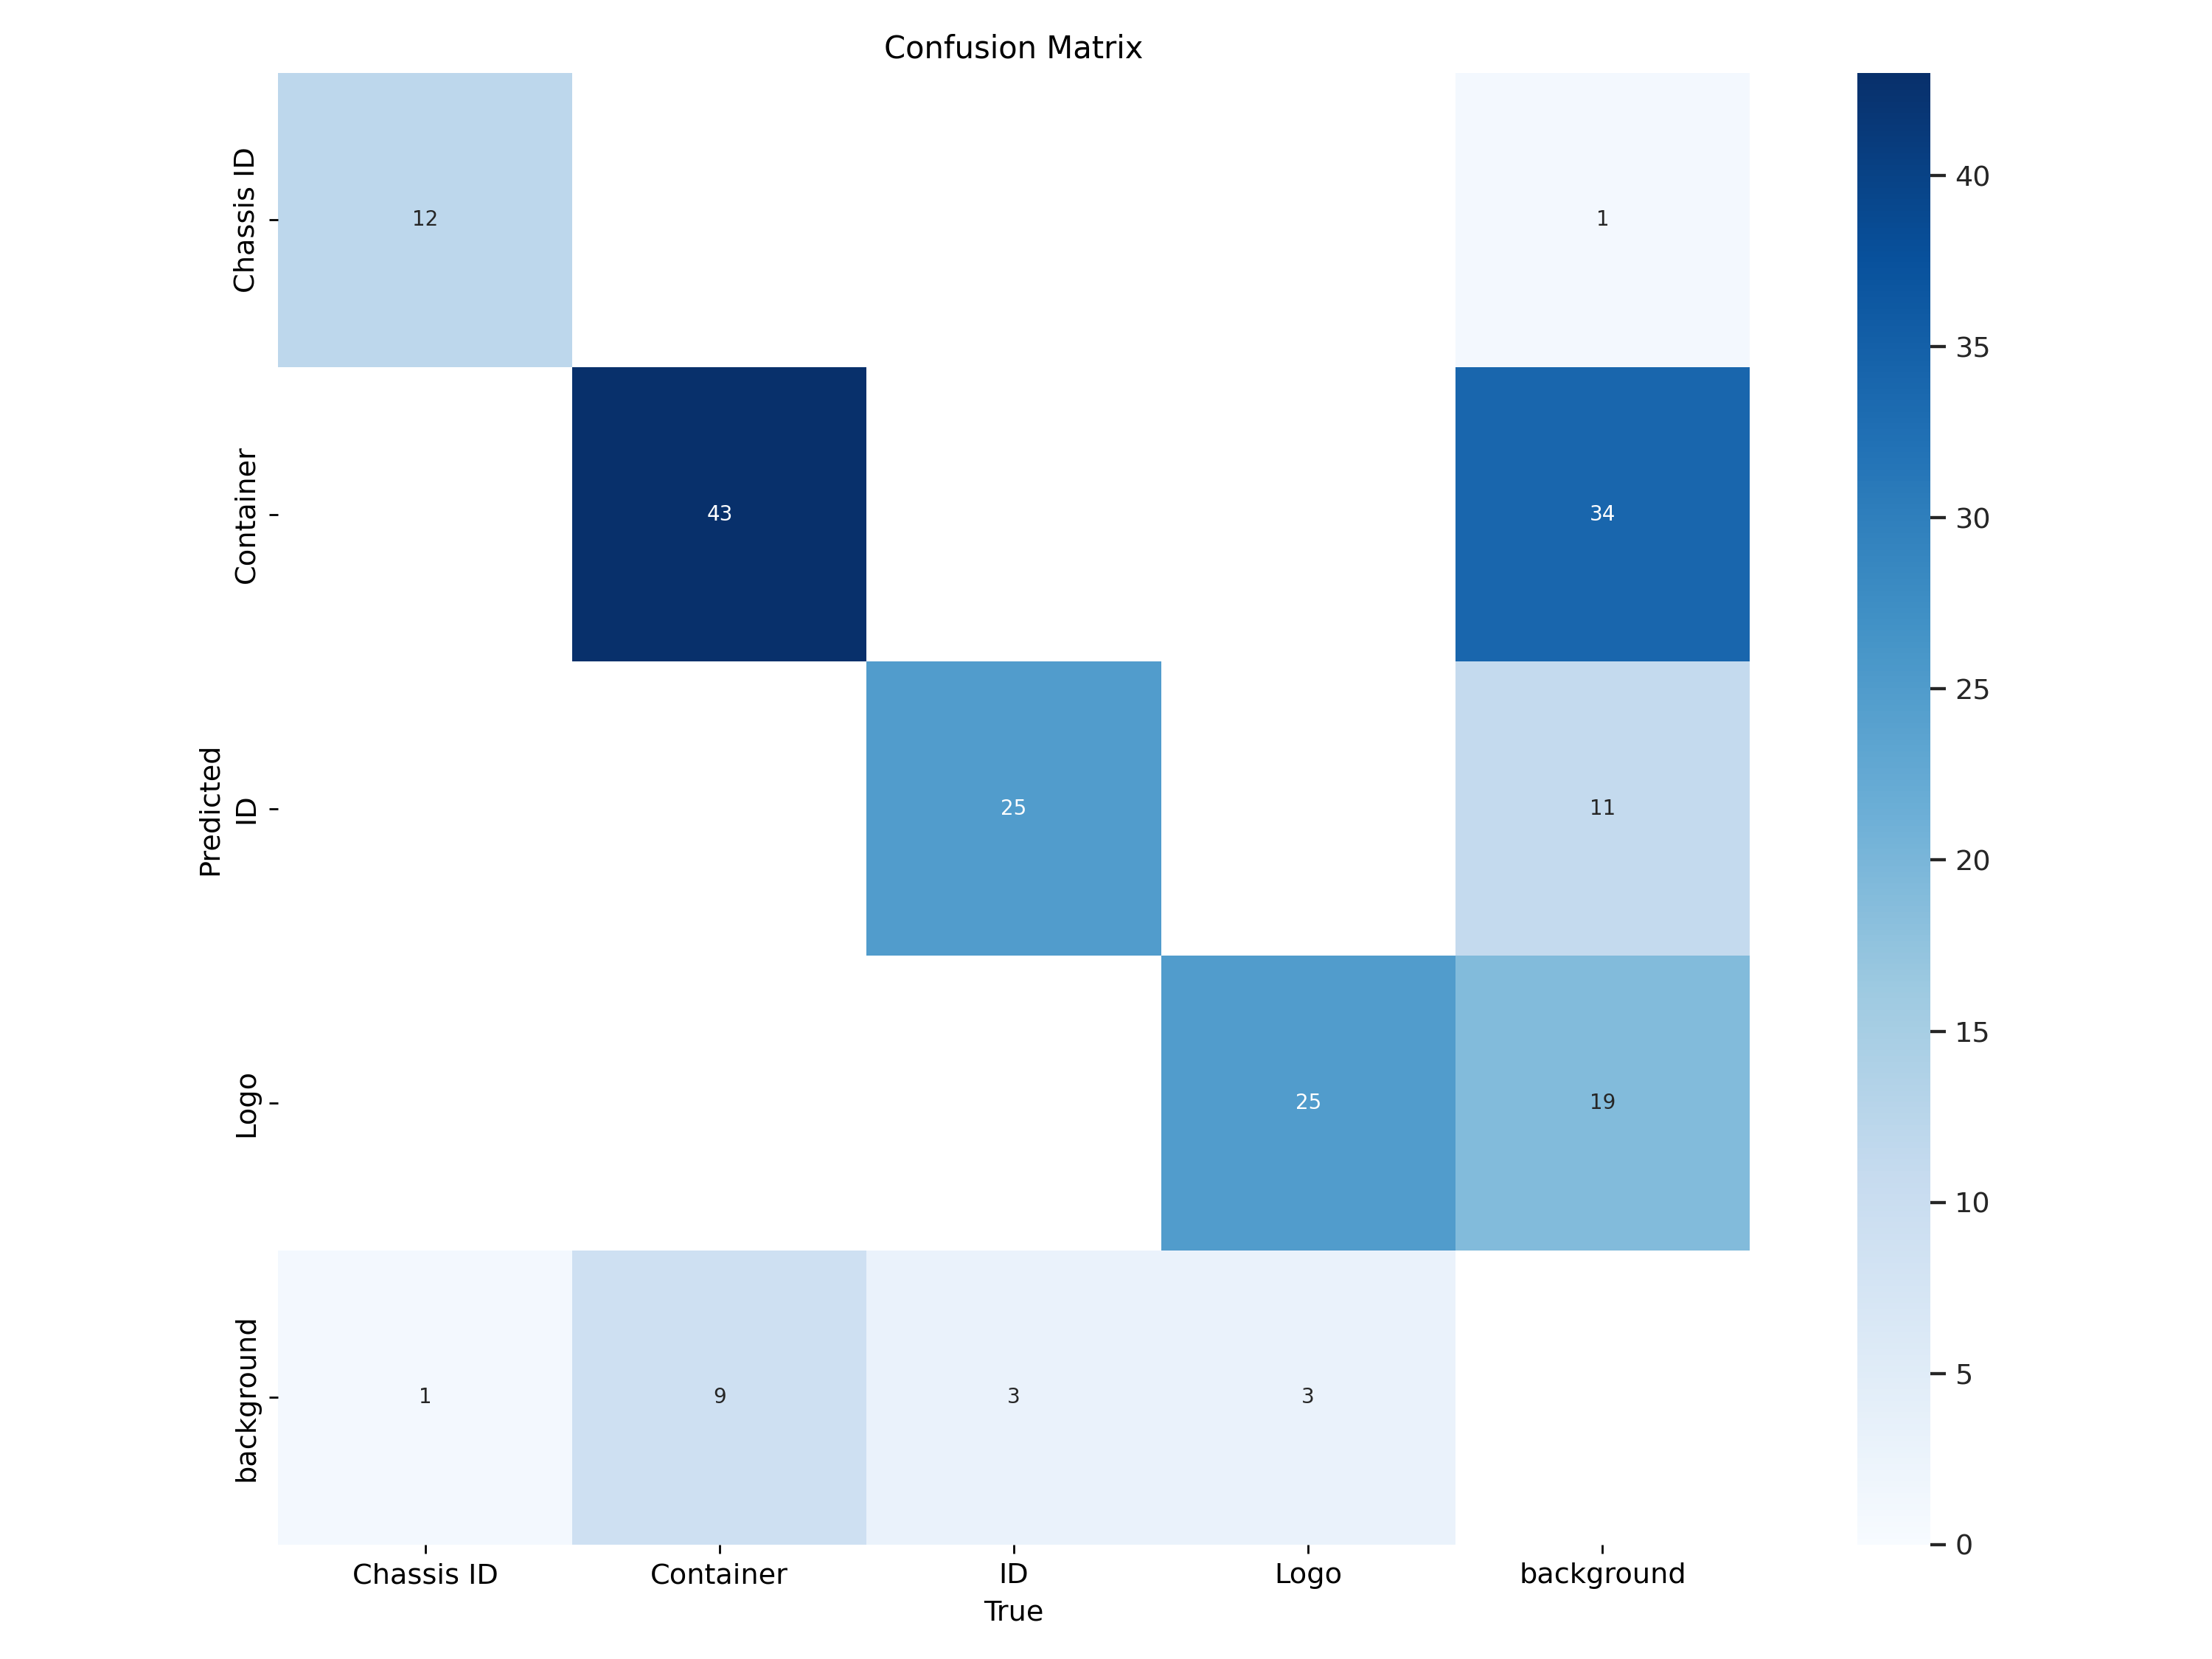

In [ ]:
from IPython.display import Image

Image(filename=f'/content/yolov12/runs/detect/train/confusion_matrix.png', width=600)

/content


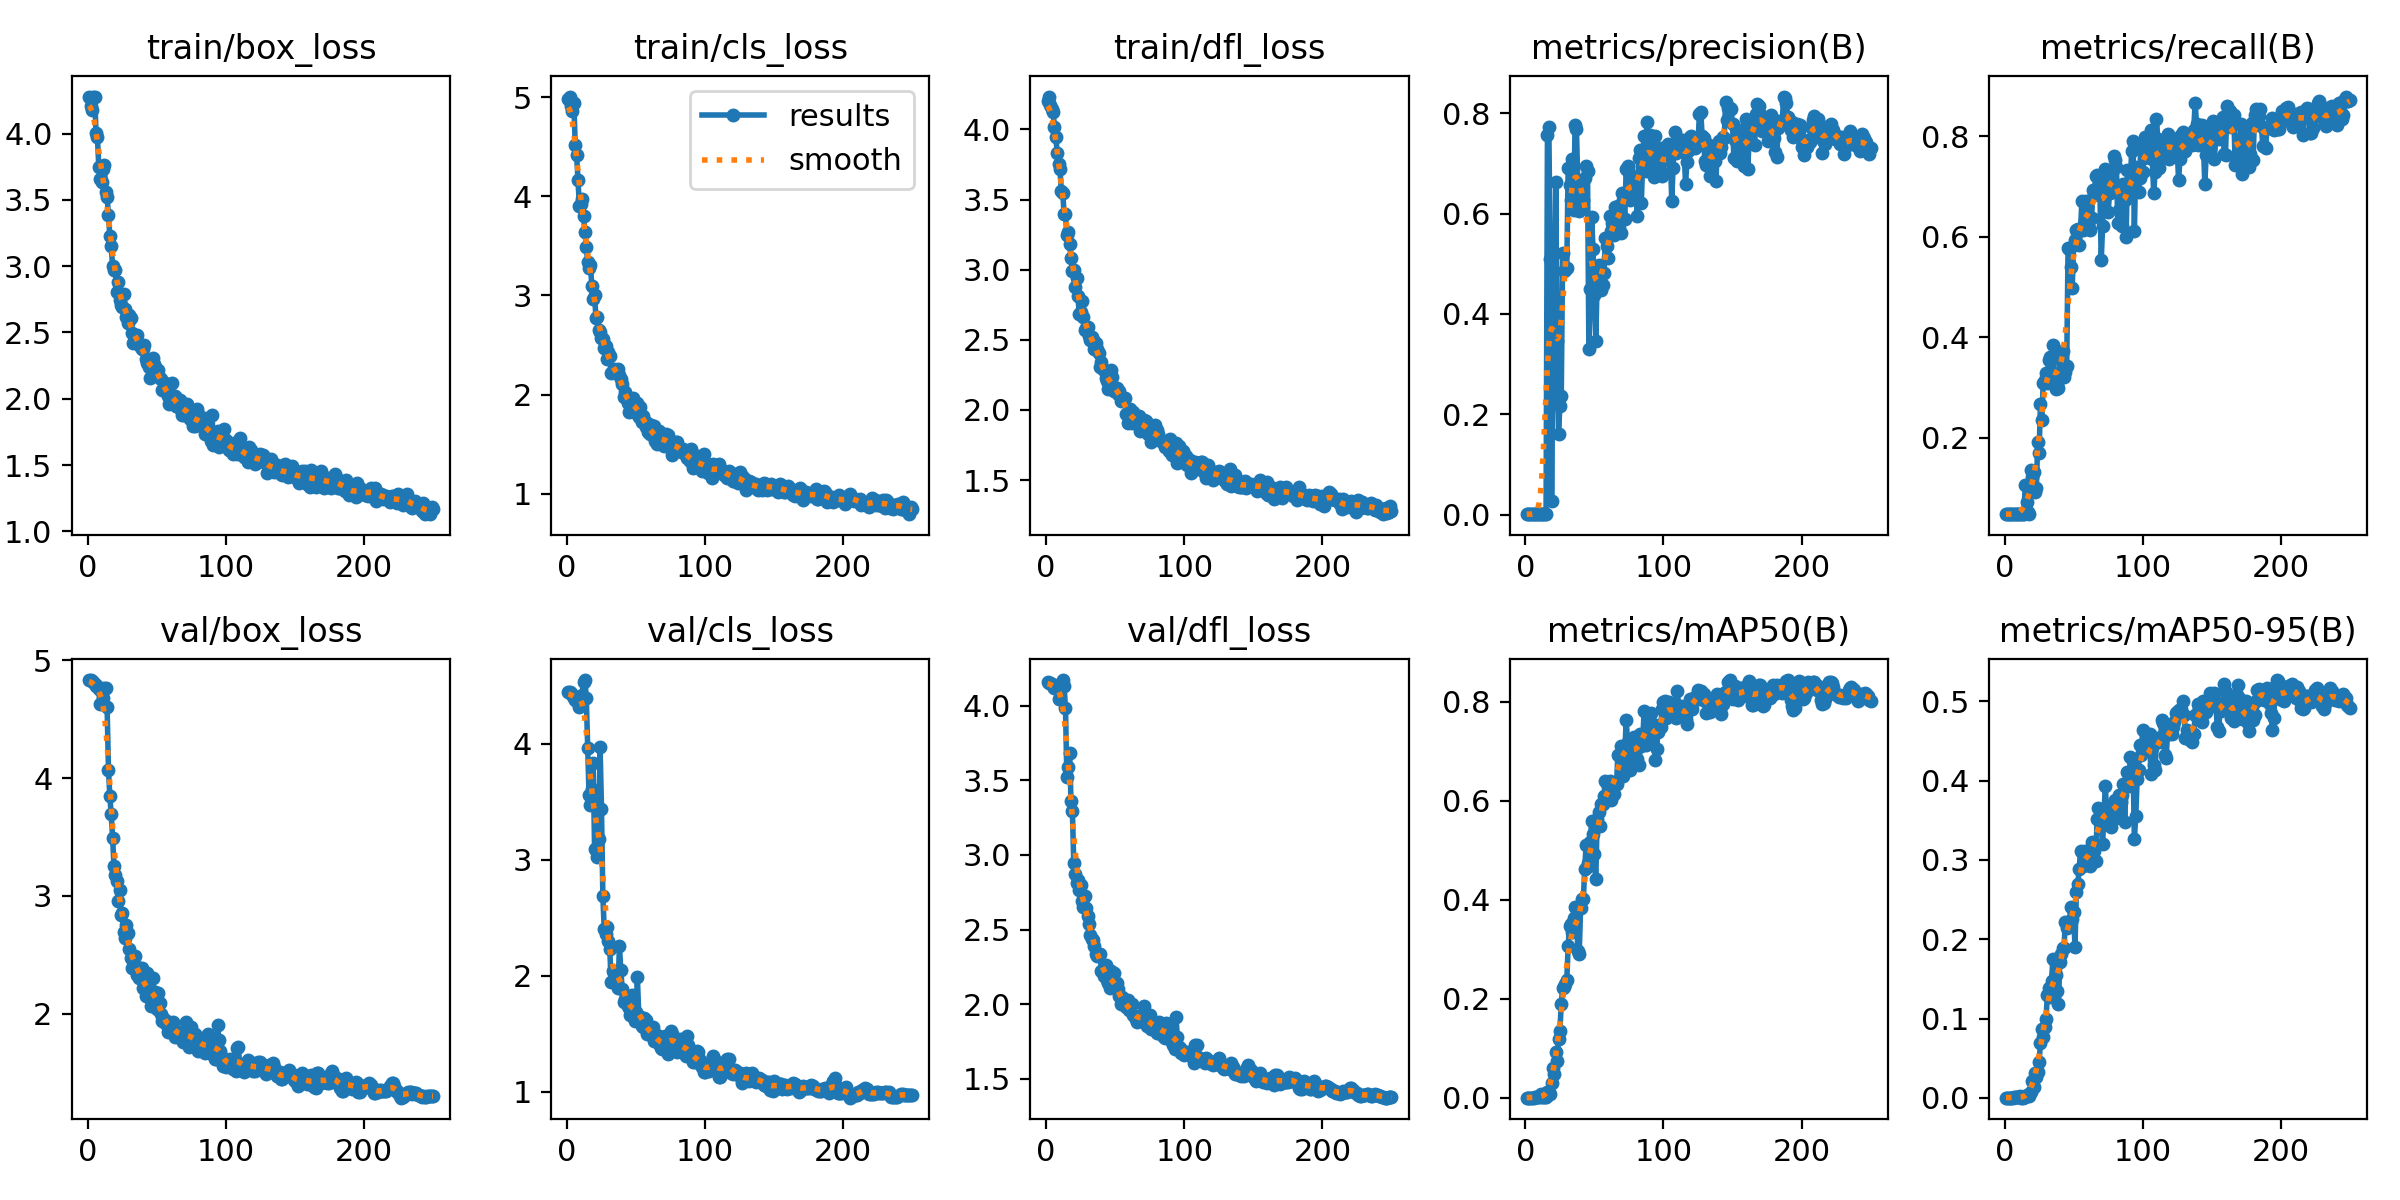

In [ ]:
%cd {HOME}
Image(filename=f'{HOME}/yolov12/runs/detect/train/results.png', width=600)

## Run inference with trained model

We can run our trained model on a random image from the `valid` set of our dataset using the following code:

In [ ]:
import random

model = YOLO(f"/{HOME}/yolov12/runs/detect/train/weights/best.pt")

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



0: 640x640 1 Chassis ID, 1 Container, 3 IDs, 1 Logo, 17.0ms
Speed: 2.1ms preprocess, 17.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


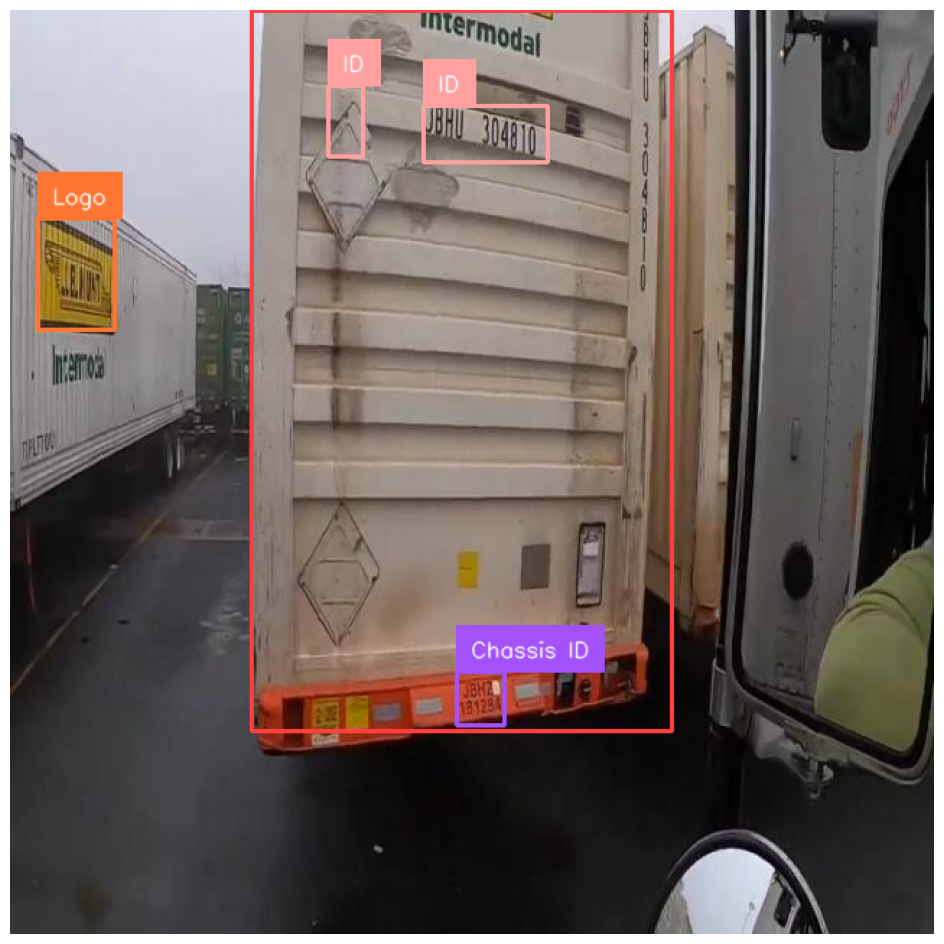

In [ ]:
image = random.choice(list(ds.images.keys()))
image = cv2.imread(image)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

results = model(image)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

Our model successfully identified objects in our image.

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.